In [1]:
from __future__ import division
import numpy as np
from acoustics.signal import EqualBand, OctaveBand, Signal, Spectrum
from acoustics.generator import Generator
import matplotlib.pyplot as plt

DEBUG = True

In [11]:
class Test(object):
    def __init__(self, fs=44100, duration=10.0, n_channels=1, signal=None, response=None, noise_type='pink', state=None):
        if signal is not None:
            pass
        if response is not None:
            pass
        
        gen = Generator(fs, duration, state) #generate n_channels dimension signal
        if noise_type == 'sine_sweep':
            self.signal, reverse_signal = gen.noise(noise_type)
        else:
            self.signal = gen.noise(noise_type)
            
        self.signal = self.signal[None, ...]
        self._fs = fs
        
        if DEBUG:
            print("Signal sample length : {0}").format(self.signal.shape[-1])
            
    def filter_octaves(self, f_start=50., f_stop=8000., fraction=3):
        """
        Bandpass filter the test signal for each octave band.
        
        :param f_start: Lowest center frequency to consider for the calculation of octave bands.
        :param f_stop: Highest center frequency to consider for the calculation of octave bands.
        
        The considered frequency range is inclusive of f_start and f_stop.
        Return the center frequencies of the octave bands
        and filtered signals for each octave band, and for each input channel.
        """
        signal_processor = Signal()
        frequencies = OctaveBand(fstart=f_start, fstop=f_stop, fraction=fraction)
        _, filtered_signal = signal_processor.bandpass_fractional_octaves(self.signal, self._fs, frequencies)
        return frequencies.center, filtered_signal
    
    def octave_spectrum(self, f_start=50., f_stop=8000., fraction=3):
        """
        Compute the power level of each octave band.
        
        :param f_start: Lowest center frequency to consider for the calculation of octave bands.
        :param f_stop: Highest center frequency to consider for the calculation of octave bands.
        
        The considered frequency range is inclusive of f_start and f_stop.
        Return the center frequencies of the octave bands and their respective power level
        """
        spectrum = Spectrum()
        frequencies = OctaveBand(fstart=f_start, fstop=f_stop, fraction=fraction)
        _, ocataves_power_levels = spectrum.third_octaves(self.signal, self._fs, frequencies=frequencies.center)
        return frequencies.center, ocataves_power_levels

Signal sample length : 441000
Octave bands : 23. 
Filtered signal : (octaves,n_channels,sequence_length) : (23L, 1L, 441000L)


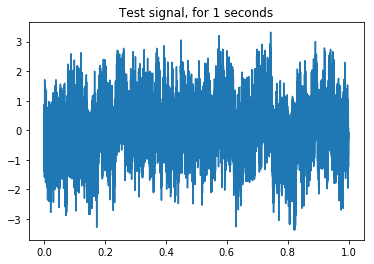

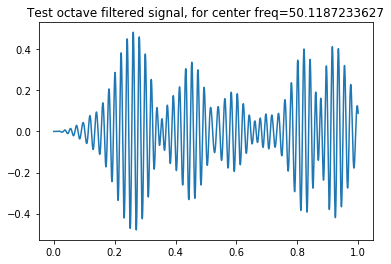

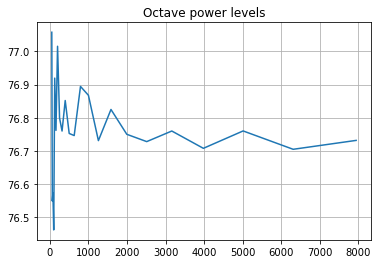

In [25]:
def main():
    fs = 44100
    duration = 10
    test = Test(noise_type='pink')
    
    octave_bands, filtered_signal = test.filter_octaves()
    octave_bands, octaves_power_levels = test.octave_spectrum()
    
    if DEBUG:
        print("Octave bands : {0}. \nFiltered signal : (octaves,n_channels,sequence_length) : {1}")\
        .format(octave_bands.size, filtered_signal.shape)
        
        test_channel = 0
        
        test_band = 0
        test_duration = 1
        T = fs * test_duration
        t = np.arange(T) / fs
        
        plt.title('Test signal, for {0} seconds'.format(test_duration))
        plt.plot(t, test.signal[test_channel, :T])
        plt.show()
        
        plt.title('Test octave filtered signal, for center freq={0}'.format(octave_bands[test_band]))
        plt.plot(t, filtered_signal[test_band, test_channel, :T])
        plt.show()
        
        plt.title('Octave power levels')
        plt.plot(octave_bands, octaves_power_levels[test_channel])
        plt.grid()
        plt.show()

main()

In [48]:
f = OctaveBand(fstart=100., fstop=5000., fraction=3)
f.center

array([  100.        ,   125.89254118,   158.48931925,   199.5262315 ,
         251.18864315,   316.22776602,   398.10717055,   501.18723363,
         630.95734448,   794.32823472,  1000.        ,  1258.92541179,
        1584.89319246,  1995.26231497,  2511.88643151,  3162.27766017,
        3981.07170553,  5011.87233627])

In [49]:
f.nominal

array([   250.,    315.,    400.,    500.,    630.,    800.,   1000.,
         1250.,   1600.,   2000.,   2500.,   3150.,   4000.,   5000.,
         6300.,   8000.,  10000.,  12500.])

In [37]:
f.nominal.size

18